In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats
data =  pd.read_json("../data.json")

def pm(angle, deg = False):
    ''' Mantém o ângulo entre +- 180/pi '''
    factor = 180 if deg else np.pi

    if angle > factor:
        while angle > factor:
            angle -= 2*factor
    if angle < factor:
        while angle < - factor:
            angle += 2*factor
    return angle

pm = np.vectorize(pm)

# Per distance

In [2]:
cap="tw"
#ds = data[data["capture"] ==cap] 
ds=data
ds.sample(3)

,index,mac,timestamp,rssi,frequency,iq,angle,distance,capture,switch_order,ref,phases,aoa
15565,84,c300000a7a46,2024-11-10 18:23:19.306000+00:00,-61,2426,"[40, -181, 163, 77, -104, 157, -149, -113, 133...",-45,848.528137,camila,2-2-0-5-6,"[-1.3532976554, 0.44131881440000004, 2.1558534...","[-0.2834601637, 1.0464756145, 2.7296231291, -2...","[-49.4444080042, -39.3114969324, -53.592582611..."
15072,194,c300000a7a46,2024-11-10 17:42:25.660000+00:00,-59,2480,"[56, -195, 155, 113, -152, 126, -110, -166, 18...",-45,212.132034,camila,2-2-0-5-6,"[-1.2911425725, 0.6299461518, 2.4494484053, -2...","[0.3194932219, 1.4253342249, -2.4948342273, -1...","[-57.1261697195, -22.9886035251, -50.514089679..."
18295,402,c300000a7a63,2024-11-10 16:34:59.462000+00:00,-55,2402,"[-170, -15, 48, -166, 154, 81, -107, 127, -106...",0,150.000000,camila,2-2-0-5-6,"[-3.0535852801, -1.2893170283, 0.4842102631000...","[0.5213263434000001, -2.1382819738, 1.16590454...","[3.4387436399, -3.1052381444, 4.8672379277, -1..."


## Modelagem da antena

In [3]:
wave_dist= (299_792_458/(2.4e6+270e3))/50
aoa = lambda pds: np.rad2deg( np.arcsin(np.clip(pm(np.array(pds[1:])-np.array(pds[:-1]) -2*99) *wave_dist/(2*np.pi),-1,1)))
ambientes = {"tw":"fechado", "camila":"aberto","poli":"semiaberto"}

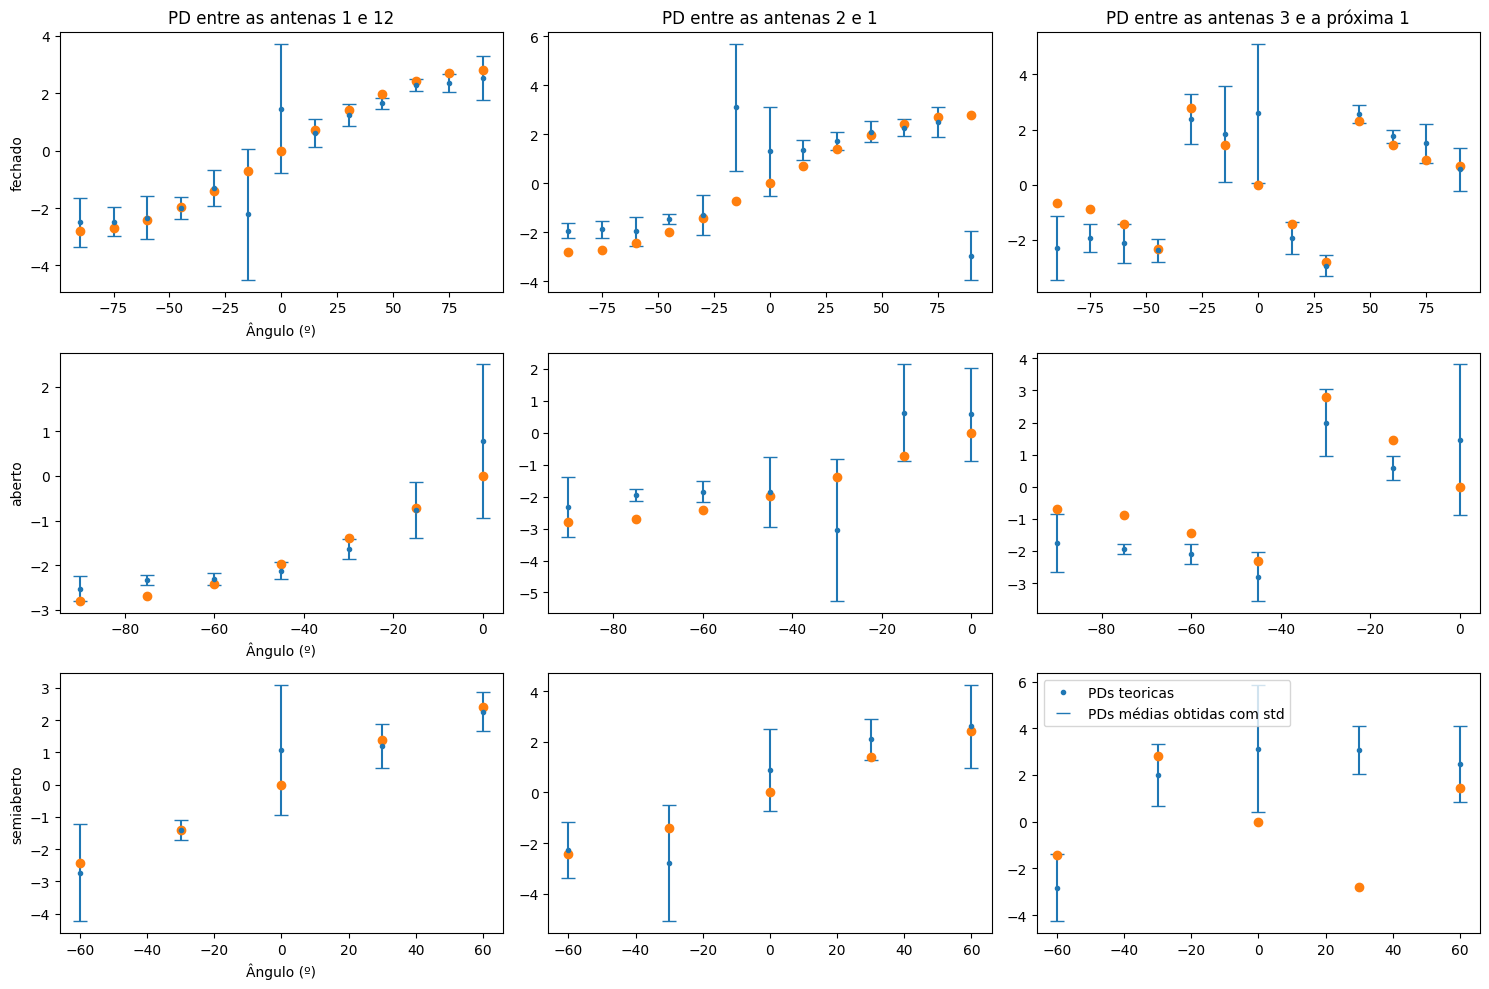

In [5]:
fig, ax = plt.subplots(3,3,figsize=(15,10))

#data["pds"] = data["phases"].map(aoa)
data["pds"] = data["phases"].map( lambda phases: pm(np.array(phases[1:])-np.array(phases[:-1])))

for plot_line, capture in enumerate(["tw","camila","poli"]):
    ds = data[data["capture"] == capture]
    angles=list(set(ds["angle"]))
    
    phase_diff_far= -pm(np.sin(np.deg2rad(angles))*2*np.pi/(wave_dist/2))
    phase_diff_adj= pm(np.sin(np.deg2rad(angles))*2*np.pi/wave_dist)

    d1,d2,d3 = [],[],[]
    for antenna, d in enumerate((d1,d2,d3)):
        std=[]
        for angle in angles:
            sample=[]
            for row in ds[ds["angle"]==angle].iterrows():
                sample = [*sample, row[1]["pds"][antenna::3]]
            d.append(pm(np.mean(sample) - np.deg2rad(99) *2 ))
            std.append(np.std(sample))

        calculated =ax[plot_line][antenna].errorbar(angles, d,std,capsize=5,fmt=".")
        sampled =ax[plot_line][antenna].plot(angles,phase_diff_adj if antenna !=2 else phase_diff_far,"o")
    ax[plot_line][0].set_ylabel(ambientes[capture])
    ax[plot_line][0].set_xlabel("Ângulo (º)")

ax[0][0].set_title("PD entre as antenas 1 e 12")
ax[0][1].set_title("PD entre as antenas 2 e 1")
ax[0][2].set_title("PD entre as antenas 3 e a próxima 1")


plt.legend(ax[0][1].lines,("PDs teoricas","PDs médias obtidas com std"))

plt.tight_layout()


KeyError: 'pds'

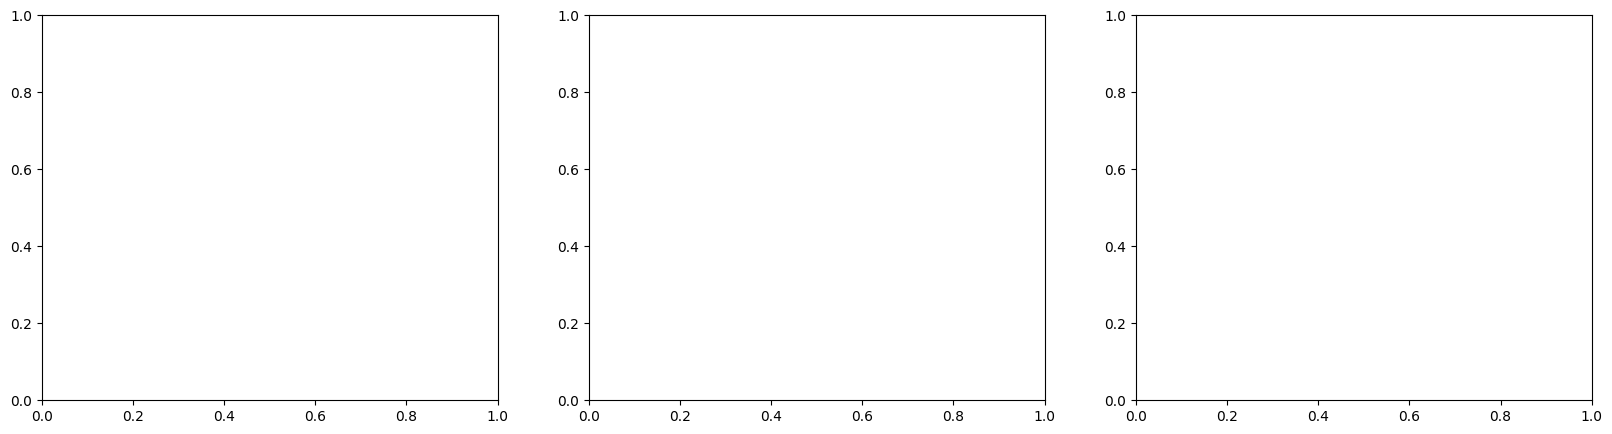

In [4]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

ds = data[data["capture"] == "tw2"]
angles=list(set(ds["angle"]))

phase_diff_far= -pm(np.sin(np.deg2rad(angles))*2*np.pi/(wave_dist/2))
phase_diff_adj= pm(np.sin(np.deg2rad(angles))*2*np.pi/wave_dist)

d1,d2,d3 = [],[],[]
for antenna, d in enumerate((d1,d2,d3)):
    std=[]
    for angle in angles:
        sample=[]
        for row in ds[ds["angle"]==angle].iterrows():
            sample = [*sample, row[1]["pds"][antenna::3]]
        d.append(pm(np.mean(sample) - np.deg2rad(99) *2 ))
        std.append(np.std(sample))

    calculated =ax[antenna].errorbar(angles, d,std,capsize=5,fmt=".")
    sampled =ax[antenna].plot(angles,phase_diff_adj if antenna !=2 else phase_diff_far,"o")
    ax[antenna].set_xlabel("Ângulo (º)")
ax[0].set_ylabel("PD (rad)")

ax[0].set_title("PD entre as antenas 1 e 12")
ax[1].set_title("PD entre as antenas 2 e 1")
ax[2].set_title("PD entre as antenas 3 e a próxima 1")


plt.legend(ax[1].lines,("PDs teoricas","PDs médias obtidas com std"))
plt.suptitle("Diferenças de fase na captura final")
plt.tight_layout()


In [44]:
rf=np.concatenate(data[data["capture"] != "tw2"]["ref"].map(lambda x: pm(np.array(x[1:])-np.array(x[:-1]))).to_numpy())

In [89]:
np.rad2deg(np.mean(rf))
np.std(np.rad2deg(rf))

6.2499822607934234

Text(0.5, 0.98, 'PDs em cada pacote por ângulo em  cada captura')

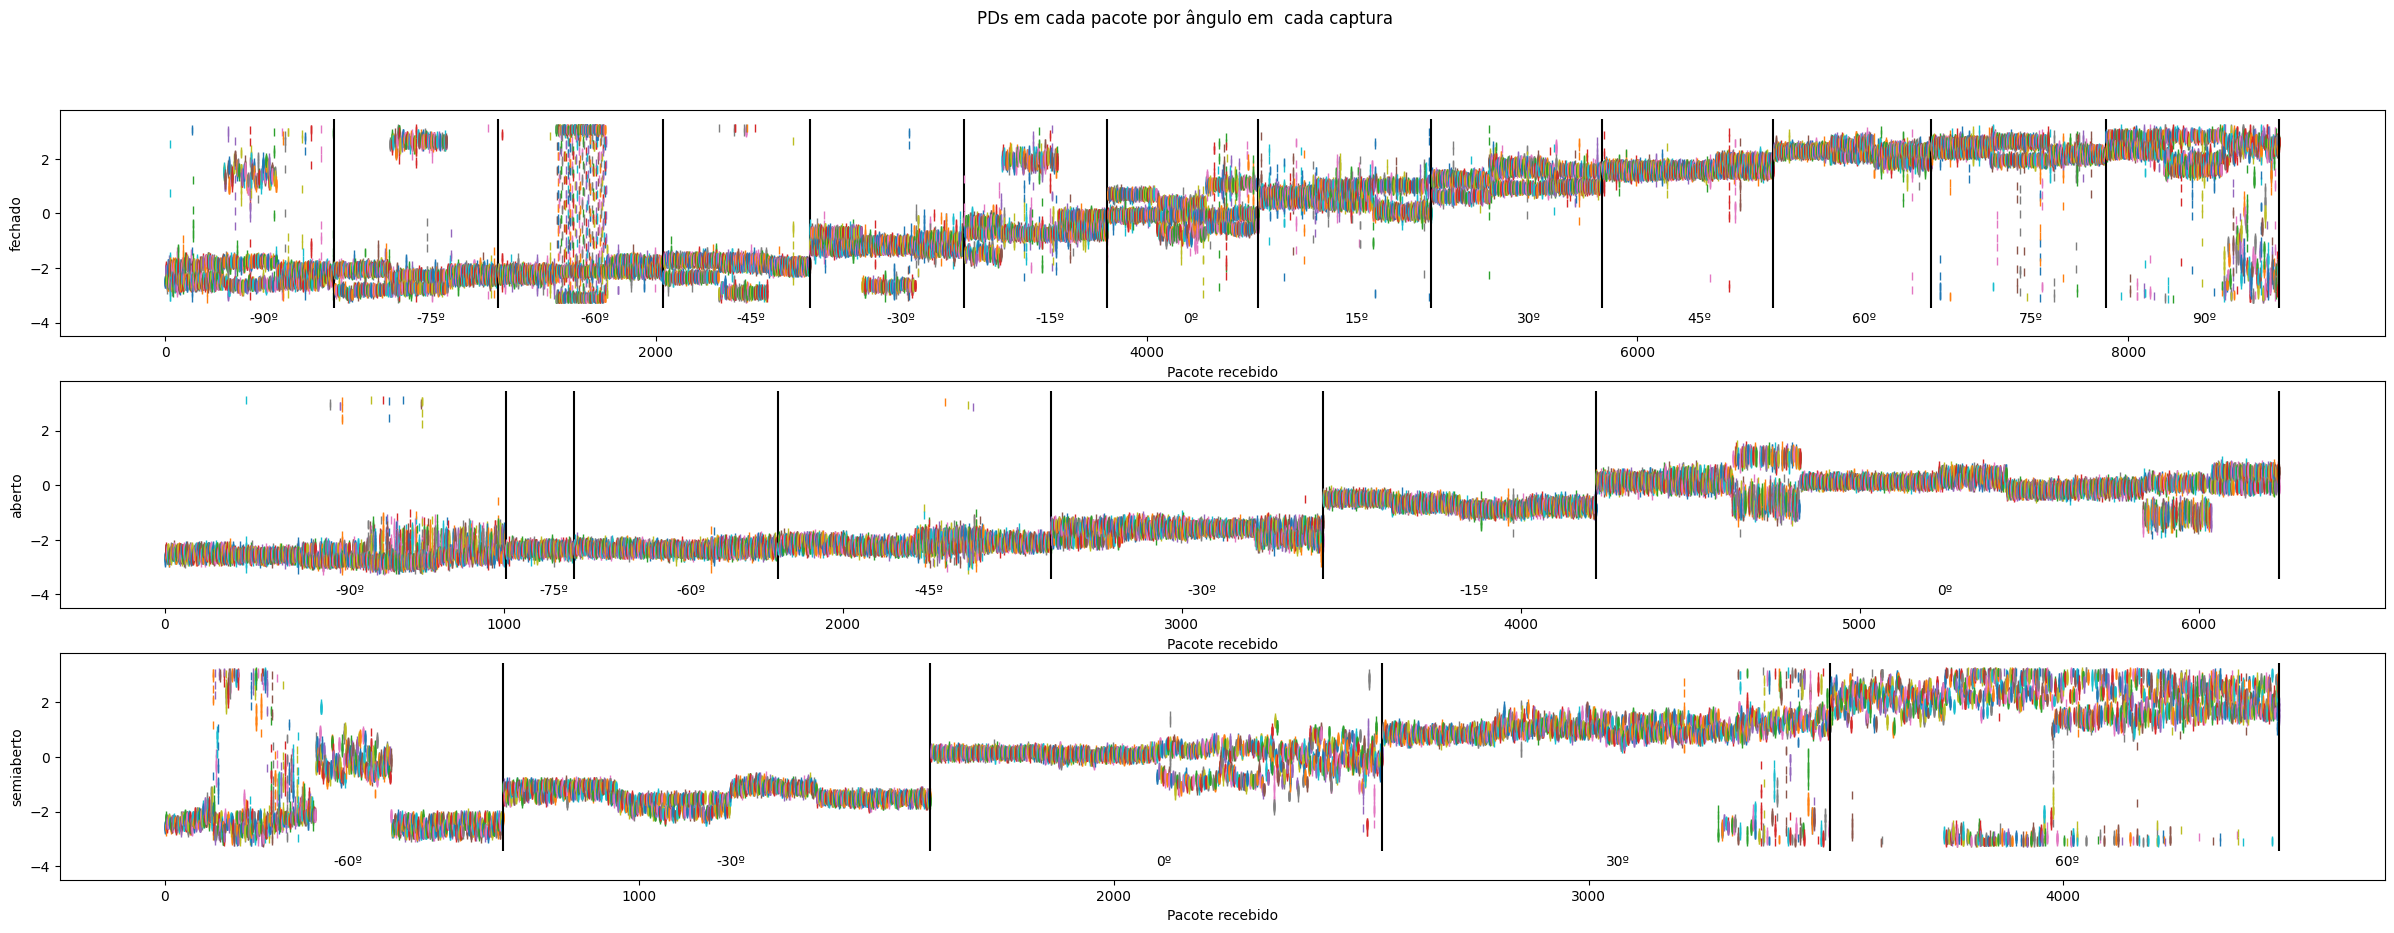

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(30,10))

for plot_line, capture in enumerate(["tw","camila","poli"]):
    ds = data[data["capture"] == capture]
    angles=list(set(ds["angle"]))
    angles.sort()
    
    x=0

    for angle in angles:
        a1=ds[ds["angle"]==angle]["pds"].map(lambda x: x[::3])
        for plot in a1:
            x+=1
            ax[plot_line].plot([x]*len(plot),pm(plot- np.deg2rad(99) *2),"|")
        ax[plot_line].vlines(x,-np.pi*1.1,np.pi*1.1,"k")
        ax[plot_line].text(x-len(a1)/2,-4,f"{angle}º")
        ax[plot_line].set_ylim(ymin=-4.5)
        ax[plot_line].set_ylabel(ambientes[capture])    
        ax[plot_line].set_xlabel("Pacote recebido")    

plt.suptitle("PDs corrigidas em cada pacote por ângulo em  cada captura")

Text(0.5, 0, 'Pacote recebido')

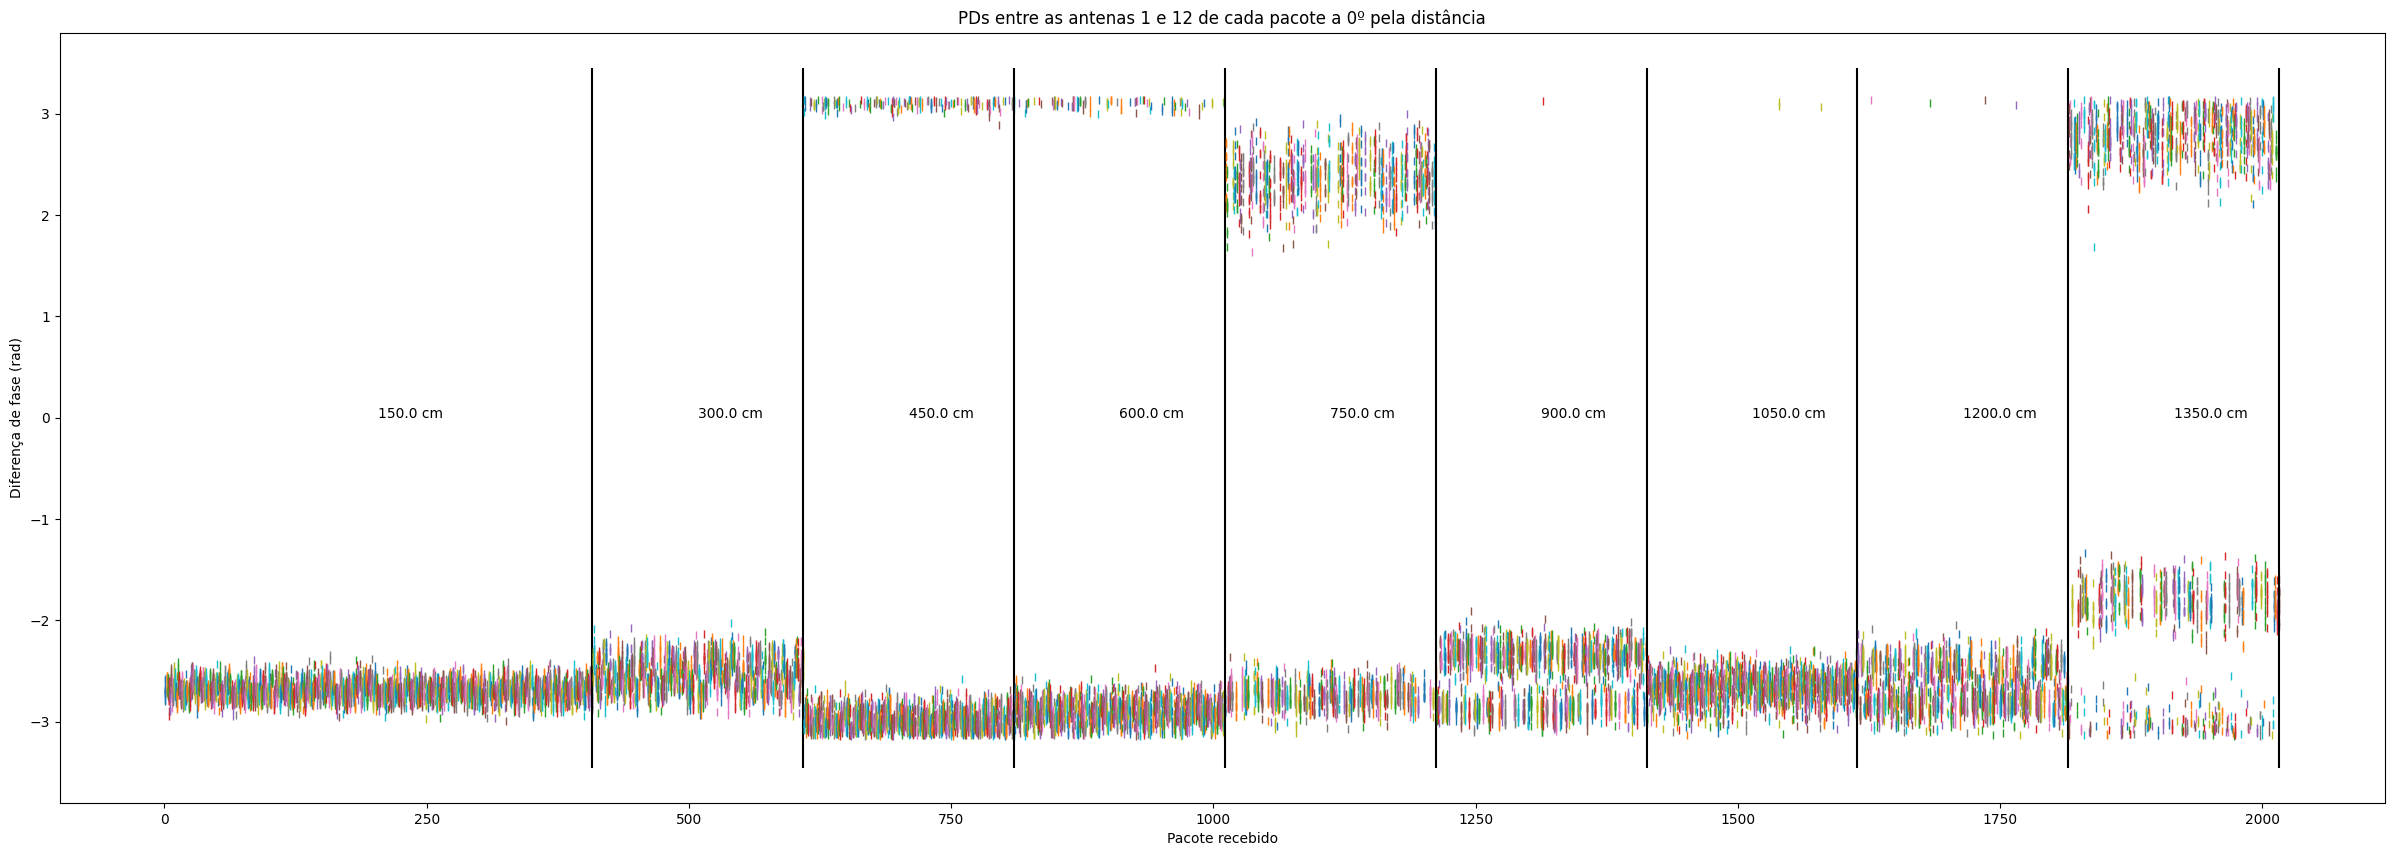

In [25]:
fig, ax = plt.subplots(1,figsize=(30,10))
angle=0

ds = data[data["capture"] == "camila"]
distances=list(set(ds[ds["angle"]==angle]["distance"]))
distances.sort()

x=0
for distance in distances:
    a1=ds[(ds["angle"]==angle) & (ds["distance"]== distance)]["pds"].map(lambda x: x[::3])
    for plot in a1:
        x+=1
        plt.plot([x]*len(plot),plot,"|")

    plt.vlines(x,-np.pi*1.1,np.pi*1.1,"k")
    plt.text(x-len(a1)/2,0,f"{distance} cm")

plt.title("PDs entre as antenas 1 e 12 de cada pacote a 0º pela distância")
plt.ylabel("Diferença de fase (rad)")
plt.xlabel("Pacote recebido")    


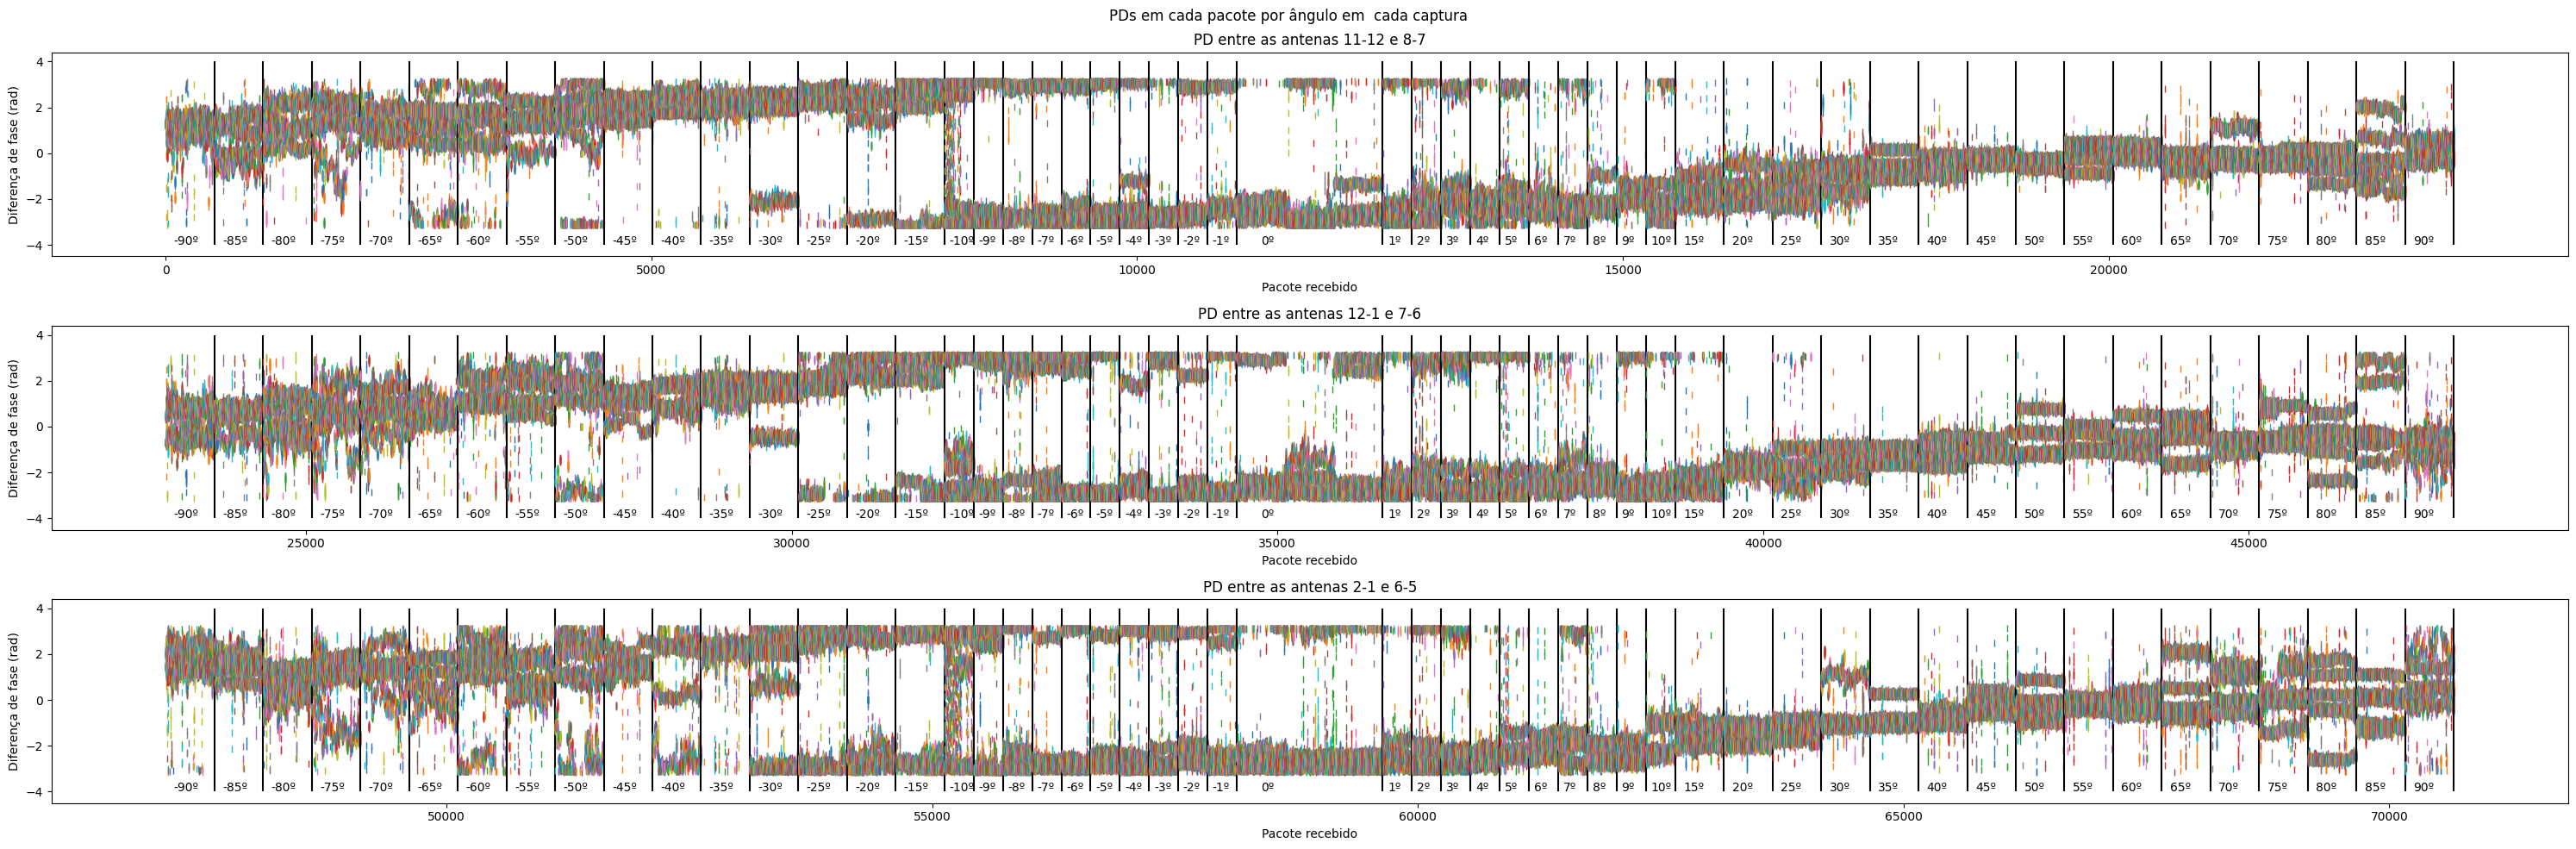

In [8]:
fig, ax = plt.subplots(3,1,figsize=(30,10))

ds = data[data["capture"] == "tw2"]
angles=list(set(ds["angle"]))
angles.sort()

x=0
nomes=["11-12 e 8-7","12-1 e 7-6","2-1 e 6-5"]
for i in range(3):
    for angle in angles:
        a1=ds[ds["angle"]==angle]["pds"].map(lambda x: x[i::4])
        for plot in a1:
            x+=1
            ax[i].plot([x]*len(plot),plot,"|")
        ax[i].vlines(x,-4,4,"k")
        ax[i].text(x-len(a1)/1.2,-4,f"{angle}º")
        ax[i].set_ylim(ymin=-4.5)
    ax[i].set_ylabel("Diferença de fase (rad)")    
    ax[i].set_xlabel("Pacote recebido")
    ax[i].set_title("PD entre as antenas " + nomes[i])    

plt.suptitle("PDs em cada pacote por ângulo em  cada captura")
plt.tight_layout()

In [ ]:
x

[0, 1, 2]